In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import pickle
from rich.progress import track

sns.set(color_codes=True, style="white")

### Load Data

In [35]:
folder_PCF = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/PCF-RNA"
os.chdir(folder_PCF)
p_files = [f for f in os.listdir(".") if f.endswith(".p")]
conditions = [f.split("PairCorr-DataDict-pooled-")[-1][:-2] for f in p_files]
conditions_ordered = [
    "FL_2x",
    "ActB_2x",
    "GAPDH_2x",
    "PB1_SPEN_2x",
    "PB2_CXCR2_2x",
    "THOR_2x",
    "THORdel_2x",
    "SG1_AHNAK_2x",
    "SG2_DYNC1H1_2x",
    "SG3_NORAD_2x",
    "ActB_1x",
    "GAPDH_1x",
    "THOR_1x",
]

### Functions

In [30]:
def weighted_stats(lst_PCF_per_cell, lst_N_locations):
    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_cell[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array([lst_PCF_per_cell[j][i] for j in range(N_condensates)])
        # remove nan
        mask = np.isnan(data_array) | np.isnan(weights)
        data_array = data_array[~mask]
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights[~mask])
        # calculate the variance
        variance = np.average(
            (data_array - weighted_mean[i]) ** 2, weights=weights[~mask]
        )
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std


def cluster_model(r, A, r0):
    # r0 is the characteristic size of clustering
    Gr = 1 + A * np.exp(-r / r0)
    return Gr


def coscos_PCF(r, a1, b1, c1, a2, b2, c2, d):
    # a is amplitude
    # b is wave number, also called the angular frequency
    # c is phase shift
    # d is vertical shift or rest position
    Gr = a1 * np.cos(b1 * r + c1) + a2 * np.cos(b2 * r + c2) + d
    return Gr


def red_chi(bins, A, r0, weighted_mean, weighted_std):
    # Calculate chi square
    Gr_fitted = cluster_model(bins, A, r0)
    residuals = weighted_mean - Gr_fitted
    variance = weighted_std**2
    chi_square = np.sum((residuals**2) / variance)
    # Calculate degrees of freedom
    dof = len(bins) - 2
    # Calculate reduced chi square
    reduced_chi_square = chi_square / dof
    return reduced_chi_square


def bootstrap(bins, lst_PCF_per_cell, lst_N_locations, bs_size=30, bs_rounds=100):
    lst_A = []
    lst_r0 = []
    lst_red_chi2 = []
    for i in range(bs_rounds):
        idxs = np.random.choice(len(lst_PCF_per_cell), bs_size)
        lst_PCF_bs = [lst_PCF_per_cell[idx] for idx in idxs]

        idxs = np.random.choice(len(lst_N_locations), bs_size)
        lst_N_bs = [lst_N_locations[idx] for idx in idxs]

        weighted_mean, _, weighted_std = weighted_stats(lst_PCF_bs, lst_N_bs)

        popt, _ = curve_fit(
            cluster_model,
            bins[1:],
            weighted_mean[1:],
            bounds=([-2, 0], [2, 2000]),
            maxfev=10000,
        )
        A, r0 = popt
        reduced_chi_square = red_chi(
            bins[1:], A, r0, weighted_mean[1:], weighted_std[1:]
        )

        lst_A.append(A)
        lst_r0.append(r0)
        lst_red_chi2.append(reduced_chi_square)

    return lst_A, lst_r0, lst_red_chi2

### cross weighted mean + STD

In [36]:
lst_mean = []
lst_sem = []
for condition in track(conditions_ordered):
    dict_toplot = pickle.load(
        open("PairCorr-DataDict-pooled-" + condition + ".p", "rb")
    )
    nm_per_pxl = dict_toplot["nm_per_pxl"]
    r_max_nm = dict_toplot["r_max_nm"]
    ringwidth_nm = dict_toplot["ringwidth_nm"]
    dr_slidingrings_nm = dict_toplot["dr_slidingrings_nm"]
    bins = dict_toplot["bins"]

    # Calculate the weighted mean, STD, SEM
    lst_PCF_per_cell = dict_toplot["lst_cross"]
    lst_N_loc_condensate = dict_toplot["lst_N_loc_condensate"]
    lst_N_loc_RNA = dict_toplot["lst_N_loc_RNA"]
    lst_PCF_per_cell_norm = []
    lst_N_locations = []
    for current_PCF, a, b in zip(lst_PCF_per_cell, lst_N_loc_condensate, lst_N_loc_RNA):
        if np.mean(current_PCF[-10:]) == 0:
            continue
        lst_PCF_per_cell_norm.append(current_PCF / np.mean(current_PCF[-10:]))
        lst_N_locations.append(a + b)

    weighted_mean, weighted_sem, weighted_std = weighted_stats(
        lst_PCF_per_cell_norm, lst_N_locations
    )
    lst_mean.append(weighted_mean[0])
    lst_sem.append(weighted_sem[0])

    # Plot weighted mean curves + STD
    plt.figure(figsize=(4, 3))
    plt.axhline(1, c="gray", ls="--")
    plt.errorbar(
        bins,
        weighted_mean,
        yerr=weighted_sem,
        fmt="o",
        color="k",
        ecolor="k",
        elinewidth=1,
        capsize=2,
        alpha=0.5,
    )
    plt.xlim(bins[0], bins[-1])
    plt.ylim(0.5, 1.5)
    plt.xlabel("r, nm", fontsize=17)
    plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
    plt.gca().spines[:].set_linewidth(2)
    plt.gca().tick_params(
        axis="both",
        which="major",
        labelsize=17,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=2,
    )

    plt.title(", ".join(condition.split("_")), fontsize=17, weight="bold")
    plt.savefig(
        "cross_PCF_" + condition + "_weighted_mean_SEM.png",
        format="png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.close()

Output()

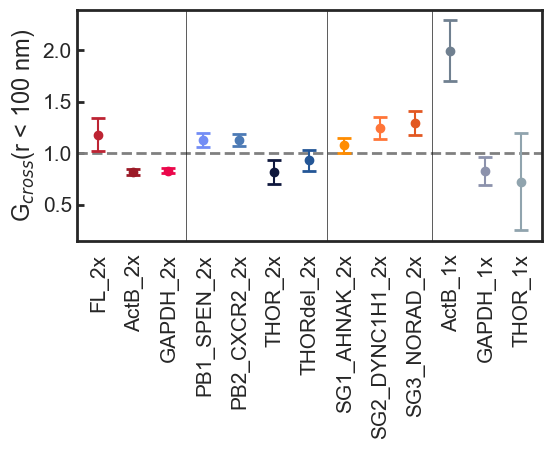

In [93]:
colors = [
    "#BD2433",  # FL
    "#9C1A27",  # ActB
    "#EB074B",  # GAPDH
    "#738DF5",  # PB1
    "#4C7AB5",  # PB2
    "#0F183D",  # THOR
    "#245696",  # THORdel
    "#FF8C00",  # SG1
    "#FF7538",  # SG2
    "#E25822",  # SG3
    "#708090",  # ActB, 1x
    "#8C92AC",  # GAPDH, 1x
    "#90A4AE",  # THOR, 1x
]
plt.figure(figsize=(6, 3))
x_pos = np.arange(len(conditions_ordered))
# lines for eyes
plt.axhline(1, c="gray", ls="--", lw=2)
plt.axvline((x_pos[2] + x_pos[3]) / 2, c="k", lw=0.5)
plt.axvline((x_pos[6] + x_pos[7]) / 2, c="k", lw=0.5)
plt.axvline((x_pos[9] + x_pos[10]) / 2, c="k", lw=0.5)
# plot
for i in range(len(conditions_ordered)):
    plt.errorbar(
        x_pos[i],
        lst_mean[i],
        yerr=lst_sem[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.ylabel(r"G$_{cross}$(r < 100 nm)", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="major",
    labelsize=15,
)
plt.xticks(x_pos + 0.3, conditions_ordered, rotation=90, ha="right")
plt.savefig(
    "doterrorplot_firstbin_weighted_mean_SEM.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

### Unused

In [32]:
# # Plot individual curves for perLoc
# lst_PCF_per_cell = dict_toplot["lst_cross"]
# lst_PCF_per_cell_norm = [
#     current_PCF / np.mean(current_PCF[-10:]) for current_PCF in lst_PCF_per_cell
# ]
# plt.figure(figsize=(4, 3))
# plt.axhline(1, c="k", ls="--")

# for current_PCF in lst_PCF_per_cell_norm:
#     plt.plot(bins, current_PCF, c="#6209ba", alpha=0.3)


# plt.xlim(bins[0], bins[-1])
# plt.ylim(0.5, 1.5)
# plt.xlabel("r, nm", fontsize=17)
# plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
# plt.gca().spines[:].set_linewidth(2)
# plt.gca().tick_params(
#     axis="both",
#     which="major",
#     labelsize=17,
#     direction="in",
#     bottom=True,
#     left=True,
#     length=5,
#     width=2,
# )
# plt.title(", ".join(condition.split("_")), fontsize=17, weight="bold")
# plt.savefig(
#     "cross_PCF_" + condition + "_individual.png",
#     format="png",
#     bbox_inches="tight",
#     dpi=300,
# )

In [33]:
# # Calculate the weighted mean, STD, SEM
# lst_PCF_per_cell = dict_toplot["lst_cross"]
# lst_PCF_per_cell_norm = [
#     current_PCF / np.mean(current_PCF[-10:]) for current_PCF in lst_PCF_per_cell
# ]
# lst_N_loc_condensate = dict_toplot["lst_N_loc_condensate"]
# lst_N_loc_RNA = dict_toplot["lst_N_loc_RNA"]
# lst_N_locations = [a + b for a, b in zip(lst_N_loc_condensate, lst_N_loc_RNA)]

# weighted_mean, weighted_sem, weighted_std = weighted_stats(
#     lst_PCF_per_cell_norm, lst_N_locations
# )

# # calculate the characteristic cluster size by fitting
# # popt, pcov = curve_fit(
# #     cluster_model,
# #     bins[1:],
# #     weighted_mean[1:],
# #     bounds=([-2, 0], [2, 2000]),
# #     maxfev=10000,
# #     # full_output=True,
# # )
# # A, r0 = popt
# # A_error, r0_error = np.sqrt(np.diag(pcov))
# # reduced_chi_square = red_chi(bins, A, r0, weighted_mean, weighted_std)

# # Plot weighted mean curves + STD
# plt.figure(figsize=(4, 3))
# plt.axhline(1, c="gray", ls="--")
# plt.errorbar(
#     bins,
#     weighted_mean,
#     yerr=weighted_sem,
#     fmt="o",
#     color="#6209ba",
#     ecolor="#6209ba",
#     elinewidth=1,
#     capsize=2,
#     alpha=0.5,
# )
# # r_fit = np.linspace(bins[0], bins[-1], 500)
# # gr_fit = cluster_model(r_fit, A, r0)
# # plt.plot(r_fit, gr_fit, c="#6209ba", lw=3)
# plt.xlim(bins[0], bins[-1])
# plt.ylim(0.5, 1.5)
# plt.xlabel("r, nm", fontsize=17)
# plt.ylabel(r"G$_{cross}$(r)", fontsize=17)
# plt.gca().spines[:].set_linewidth(2)
# plt.gca().tick_params(
#     axis="both",
#     which="major",
#     labelsize=17,
#     direction="in",
#     bottom=True,
#     left=True,
#     length=5,
#     width=2,
# )

# # Bootstrapping
# # lst_A, lst_r0, lst_red_chi2 = bootstrap(
# #     bins,
# #     lst_PCF_per_cell_norm,
# #     lst_N_locations,
# #     40,
# #     1000,
# # )
# # ci_A = (np.percentile(lst_A, 5), np.percentile(lst_A, 95))
# # bs_A_mean = np.mean(ci_A)
# # bs_A_err = (ci_A[1] - ci_A[0]) / 2
# # ci_r0 = (np.percentile(lst_r0, 5), np.percentile(lst_r0, 95))
# # bs_r0_mean = np.mean(ci_r0)
# # bs_r0_err = (ci_r0[1] - ci_r0[0]) / 2

# # plt.text(
# #     950,
# #     1.35,
# #     r"A = " + str(round(bs_A_mean, 2)) + r" $\pm$ " + str(round(bs_A_err, 2)),
# #     fontsize=17,
# #     color="#6209ba",
# #     horizontalalignment="right",
# # )
# # plt.text(
# #     950,
# #     1.2,
# #     r"R = "
# #     + "{:.0f}".format(round(bs_r0_mean, -2))
# #     + r" $\pm$ "
# #     + "{:.0f}".format(round(bs_r0_err, -2))
# #     + " nm",
# #     fontsize=17,
# #     color="#6209ba",
# #     horizontalalignment="right",
# # )
# plt.title(", ".join(condition.split("_")), fontsize=17, weight="bold")
# plt.savefig(
#     "cross_PCF_FUSref_" + condition + "_weighted_mean_SEM.png",
#     format="png",
#     bbox_inches="tight",
#     dpi=300,
# )